# Proactive Management of Model Deployment: Predicting Performance Degradation and Service Failure

## Summary

This notebook is designed to provide a predictive framework for managing and maintaining your machine learning models using DataRobot MLOPs.
It focuses on preemptively identifying potential model performance degradation and service failures, enabling your organization to proactively address these issues before they adversely impact operations. 
This approach ensures the sustained efficiency and reliability of predictions that are integral to your business operations.

Early detection of model performance deterioration allows for timely interventions. 
These interventions could range from adjusting DataRobot's retraining policies to other corrective actions, ensuring the maintenance of optimal model performance. 
Similarly, predicting potential service infrastructure issues facilitates preemptive maintenance. 
This not only reduces downtime but also enhances service reliability and provides insights into the root causes of these issues.

The notebook demonstrates how to leverage DataRobot MLOps functionality to predict if a machine learning model is likely to degrade within a specific time period and if infrastructure failures may occur. 
It utilizes DataRobot's Python AI capabilities to collect various characteristics and metrics that DataRobot MLOPs tracks for your deployed model, thereby enabling the construction of a predictive model."

This notebook outlines how to:

1. Setup: connect to DataRobot and Deployment
    - Establish a connection with DataRobot and access the relevant deployment details.
2. Create a training dataset
    - Service Health and Stats features
    - Data Drift features
    - Model Accuracy features
    - Predictions Over Time features
    - [optionally] Model Fairness features
3. Define a target for predicting Model Performance Degradation
4. Build a TS Model Degradation project 
5. Define a target for predicting Service Failure
6. Build a TS Service Failure project
7. Retrieve modeling results from the DataRobot Projects
8. Next steps to augument original deployment with custom metrics based on these predictions

## Setup

### Import libraries

In [1]:
from datetime import datetime, timedelta
from functools import reduce
import os
import warnings

import datarobot as dr
from datarobot.helpers.partitioning_methods import construct_duration_string
import datarobotx as drx
from dateutil.parser import parse
import numpy as np
import pandas as pd
import plotly.express as px
import plotly.graph_objects as go

### Bind variables

In [2]:
# These variables can aso be fetched from a secret store or config files
DATAROBOT_ENDPOINT = "https://app.datarobot.com/api/v2"
# The URL may vary depending on your hosting preference, the above example is for DataRobot EU Managed AI Cloud

DATAROBOT_API_TOKEN = "<INSERT YOUR DataRobot API Token>"
# The API Token can be found by click the avatar icon and then </> Developer Tools

### Connect to DataRobot and DRX client

You can read more about different options for [connecting to DataRobot from the client](https://docs.datarobot.com/en/docs/api/api-quickstart/api-qs.html). <br>
And [connecting to datarobotx](https://drx.datarobot.com/quickstart.html)

In [3]:
client = dr.Client(
    os.path.expanduser("~/drconfig.yaml"), trace_context="AI-E2E-VP-00001"
)  # or
# client = dr.Client(token=DATAROBOT_API_TOKEN, endpoint=DATAROBOT_ENDPOINT, trace_context="AI-E2E-VP-00001")
config = drx.DRConfig()

### Get DataRobot Deployment

In [4]:
# Set the deployment ID
deployment_id = "62324b79079ece29cf5eafde"  # "<INSERT YOUR DEPLOYMENT ID>""

deployment = dr.Deployment.get(deployment_id)

This notebook demonstrates an example based on deployment of a binary classification model to predict which mortgage loans are likely to default. <br> 
This model has been deployed for almost 2 years and over this time period has made around 690K predictions.
<br/><br/>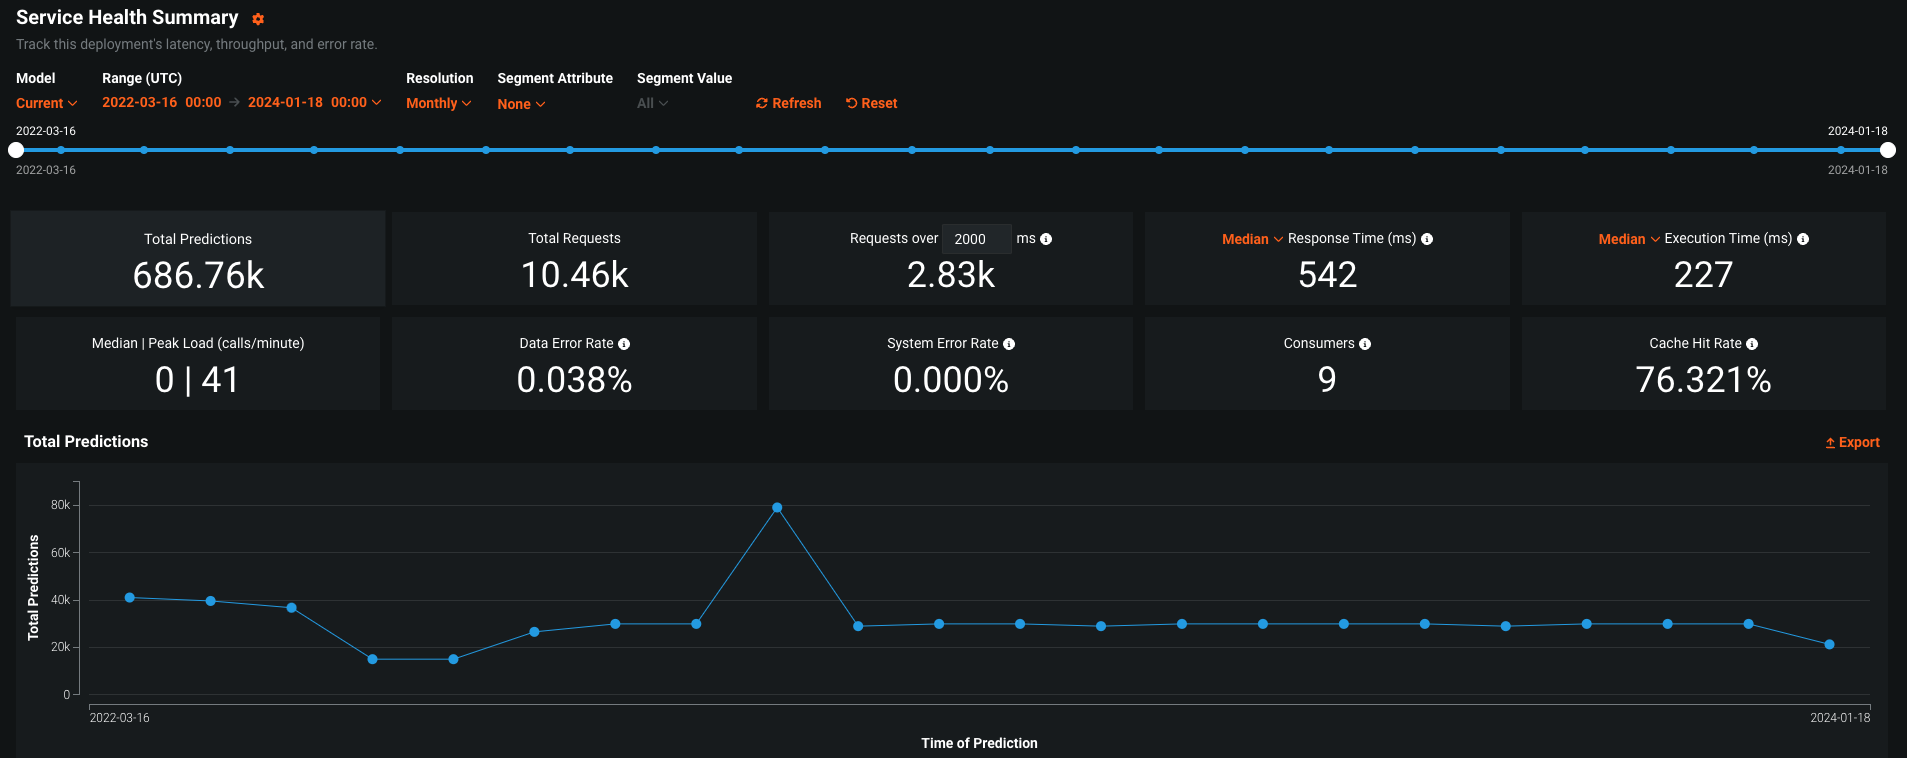

## Creating a training dataset

Before we will get different deployment characterists that will serve as features to our predictive model, let's first select the date range for our data:

In [5]:
start_of_export_window = parse("2022-03-16")
end_of_export_window = parse("2024-01-16")

In [6]:
def visualize_feature_over_time(df: pd.DataFrame, feature_name: str):
    """
    Visualizes a feature over time using Plotly.

    Parameters:
    df (pd.DataFrame): DataFrame containing the data to visualize.
    feature_name (str): The name of the feature to visualize.
    """
    plot_df = df.copy()

    with warnings.catch_warnings():
        warnings.simplefilter("ignore", FutureWarning)

        # plot_df['period.start'] = pd.to_datetime(plot_df['period.start'])
        # df_melted = plot_df.melt(id_vars='period.start', var_name=feature_name, value_name='metric')

        # Create a line chart using Plotly
        fig = px.line(
            plot_df,
            x="period.start",
            y=feature_name,
            title=f"{feature_name} Over Time",
            labels={"period.start": "Date"},
        )

        # Show the figure
        fig.show()


def get_service_stats_features(
    deployment: dr.Deployment,
    start_of_export_window: datetime,
    end_of_export_window: datetime,
) -> pd.DataFrame:
    """
    Retrieves service statistics features from DataRobot deployment within the given date range.

    Parameters:
    deployment (dr.Deployment): The deployment object from DataRobot.
    start_of_export_window (datetime): The start date for the export window.
    end_of_export_window (datetime): The end date for the export window.

    Returns:
    pd.DataFrame: A DataFrame containing the service statistics features.
    """
    all_service_metrics = dr.enums.SERVICE_STAT_METRIC.ALL
    service_stats = pd.DataFrame()

    for metric in all_service_metrics:
        stats_bucket = deployment.get_service_stats_over_time(
            start_time=start_of_export_window,
            end_time=end_of_export_window,
            bucket_size=construct_duration_string(days=1),  # make an argument
            metric=metric,
        ).buckets

        stats_df = pd.json_normalize(stats_bucket).rename(columns={"value": metric})

        if service_stats.empty:
            service_stats = stats_df
        else:
            service_stats = pd.merge(
                service_stats, stats_df, on=["period.start", "period.end"]
            )

    service_stats["period.start"] = pd.to_datetime(
        service_stats["period.start"]
    ).dt.date
    return service_stats

In [7]:
service_stats_features = get_service_stats_features(
    deployment, start_of_export_window, end_of_export_window
)
service_stats_features.head()

,totalPredictions,period.start,period.end,totalRequests,slowRequests,executionTime,responseTime,userErrorRate,serverErrorRate,numConsumers,cacheHitRatio,medianLoad,peakLoad
0,1450,2022-03-16,2022-03-17 00:00:00+00:00,69,37,188.5,1908.0,0.0,0,1,0.753623,0,33
1,0,2022-03-17,2022-03-18 00:00:00+00:00,0,0,NaN,NaN,0.0,0,0,0.000000,0,0
2,25980,2022-03-18,2022-03-19 00:00:00+00:00,72,20,207.0,426.0,0.0,0,1,0.763889,0,25
3,480,2022-03-19,2022-03-20 00:00:00+00:00,12,8,596.0,2384.0,0.0,0,1,0.416667,0,12
4,480,2022-03-20,2022-03-21 00:00:00+00:00,28,21,196.0,3349.0,0.0,0,1,0.500000,0,28


In [8]:
visualize_feature_over_time(service_stats_features, "responseTime")

In [9]:
def get_data_drift_features(
    deployment: dr.Deployment,
    start_of_export_window: datetime,
    end_of_export_window: datetime,
) -> pd.DataFrame:
    """
    Retrieves data drift features from a DataRobot deployment over a specified time period.

    Parameters:
    deployment (dr.Deployment): The DataRobot deployment object.
    start_of_export_window (datetime): The start date for the period to analyze data drift.
    end_of_export_window (datetime): The end date for the period to analyze data drift.

    Returns:
    pd.DataFrame: A dataframe containing data drift metrics for each feature over time.
    """
    # NB: it takes time
    list_of_dates = list(
        zip(
            pd.date_range(
                start_of_export_window,
                end_of_export_window - timedelta(days=1),
                freq="d",
            ),
            pd.date_range(
                start_of_export_window + timedelta(days=1),
                end_of_export_window,
                freq="d",
            ),
        )
    )

    data_drift_df = []
    for s, e in list_of_dates:
        drift_features = {}
        drift_features["period.start"] = s.date()
        drift_features["period.end"] = e
        for metric in dr.enums.DATA_DRIFT_METRIC.ALL:
            drift_features[f"target_drift_{metric}"] = deployment.get_target_drift(
                start_time=s, end_time=e, metric=metric
            ).drift_score
            feature_drift_list = dr.models.deployment.FeatureDrift.list(
                deployment_id=deployment.id, start_time=s, end_time=e, metric=metric
            )
            for f in feature_drift_list:
                drift_features[f"drift_{f.name}_{metric}"] = f.drift_score

        data_drift_df.append(drift_features)

    return pd.DataFrame(data_drift_df)

In [10]:
data_drift_features = get_data_drift_features(
    deployment, start_of_export_window, end_of_export_window
)

In [11]:
data_drift_features.head()

,period.start,period.end,target_drift_psi,drift_THIRD_PARTY_FEATURE_2_psi,drift_THIRD_PARTY_FEATURE_3_psi,drift_AMT_GOODS_PRICE_psi,drift_AMT_CREDIT_psi,drift_THIRD_PARTY_FEATURE_1_psi,drift_DAYS_BIRTH_psi,drift_DAYS_ID_PUBLISH_psi,...,drift_DAYS_REGISTRATION_js_divergence,drift_OCCUPATION_TYPE_js_divergence,drift_ENTRANCES_MEDI_js_divergence,drift_FLOORSMAX_MODE_js_divergence,drift_FLAG_OWN_CAR_js_divergence,drift_YEARS_BEGINEXPLUATATION_AVG_js_divergence,drift_DEF_60_CNT_SOCIAL_CIRCLE_js_divergence,drift_REGION_POPULATION_RELATIVE_js_divergence,drift_AMT_REQ_CREDIT_BUREAU_MON_js_divergence,drift_NAME_FAMILY_STATUS_js_divergence
0,2022-03-16,2022-03-17,0.005434,0.013443,0.005126,0.012989,0.010171,0.010186,0.008054,0.010466,...,0.000760,0.001114,0.001966,0.002884,0.000001,0.000320,0.000546,0.000350,0.001050,None
1,2022-03-17,2022-03-18,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None
2,2022-03-18,2022-03-19,0.010538,0.016373,0.033071,0.007826,0.009298,0.029712,0.003417,0.006314,...,0.000953,0.002233,0.002354,0.001392,0.000594,0.000682,0.000350,0.000596,0.000701,None
3,2022-03-19,2022-03-20,0.010663,0.024070,0.080954,0.032482,0.030949,0.101928,0.009783,0.020141,...,0.001443,0.003543,0.001907,0.001733,0.001445,0.000963,0.000592,0.000989,0.000701,None
4,2022-03-20,2022-03-21,0.015998,0.019855,0.011658,0.055555,0.052361,0.021589,0.019336,0.018480,...,0.002265,0.005527,0.003426,0.009156,0.000024,0.000876,0.000579,0.000807,0.001852,None


In [12]:
visualize_feature_over_time(
    data_drift_features[
        data_drift_features["period.start"] > pd.to_datetime("2022-07-01").date()
    ],
    "target_drift_psi",
)

In [13]:
def get_accuracy_features(
    deployment: dr.Deployment,
    start_of_export_window: datetime,
    end_of_export_window: datetime,
) -> pd.DataFrame:
    """
    Retrieves model accuracy metrics over time for a given DataRobot deployment.

    Parameters:
    deployment (dr.Deployment): The DataRobot deployment object.
    start_of_export_window (datetime): The start date for retrieving accuracy metrics.
    end_of_export_window (datetime): The end date for retrieving accuracy metrics.

    Returns:
    pd.DataFrame: A dataframe with model accuracy metrics for each date within the specified range.
    """
    target_type = deployment.model["target_type"]

    if target_type == "Binary":
        all_metrics = dr.enums.ACCURACY_METRIC.ALL_CLASSIFICATION
    elif target_type == "Regression":
        all_metrics = dr.enums.ACCURACY_METRIC.ALL_REGRESSION
    else:
        raise NotImplementedError

    metric_features = dr.models.deployment.AccuracyOverTime.get_as_dataframe(
        deployment_id=deployment.id,
        start_time=start_of_export_window,
        end_time=end_of_export_window,
        bucket_size=construct_duration_string(days=1),  # daily
        metrics=all_metrics,
    )

    if metric_features.empty:
        return pd.DataFrame()
    else:
        metric_features["period.start"] = metric_features.index.date
        return metric_features.reset_index(drop=True)

In [14]:
accuracy_features = get_accuracy_features(
    deployment, start_of_export_window, end_of_export_window
)
accuracy_features.head()

,Accuracy,AUC,Balanced Accuracy,FVE Binomial,Gini Norm,Kolmogorov-Smirnov,LogLoss,Rate@Top5%,Rate@Top10%,TPR,PPV,F1,MCC,period.start
0,0.844688,0.791973,0.684545,0.154932,0.583946,0.435897,0.242396,0.375000,0.336735,0.492373,0.266365,0.345708,0.282589,2022-03-16
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2022-03-17
2,0.836891,0.755872,0.671206,0.133317,0.511743,0.407125,0.255490,0.416667,0.312500,0.470774,0.258204,0.333496,0.264114,2022-03-18
3,0.854309,0.814237,0.738358,0.182546,0.628474,0.543124,0.234475,0.458333,0.361702,0.599217,0.307807,0.406700,0.357396,2022-03-19
4,0.873374,0.776821,0.700207,0.144166,0.553642,0.450263,0.277419,0.375000,0.416667,0.483977,0.390430,0.432199,0.364502,2022-03-20


In [15]:
visualize_feature_over_time(accuracy_features, "AUC")

In [16]:
def get_predictions_over_time_features(
    deployment: dr.Deployment,
    start_of_export_window: datetime,
    end_of_export_window: datetime,
) -> pd.DataFrame:
    """
    Retrieves predictions over time for a given DataRobot deployment.

    Parameters:
    deployment (dr.Deployment): The DataRobot deployment object.
    start_of_export_window (datetime): The start date for retrieving predictions.
    end_of_export_window (datetime): The end date for retrieving predictions.

    Returns:
    pd.DataFrame: A dataframe with predictions and associated statistics for each date within the range.
    """
    target_type = deployment.model["target_type"]

    # get_predictions_vs_actuals_over_time
    # get_fairness_scores_over_time

    predictions_over_time = deployment.get_predictions_over_time(
        start_time=start_of_export_window,
        end_time=end_of_export_window,
        bucket_size=dr.enums.BUCKET_SIZE.P1D,  # daily
        include_percentiles=True,
    ).buckets

    # function to unpack json-like column values
    def flatten_columns(row, column_name):
        # Create a container for the new columns
        new_data = {}
        for i, d in enumerate(row[column_name]):
            for key, value in d.items():
                new_data[f"{column_name}_{key}_{i}"] = value
        return pd.Series(new_data, dtype="float64")

    pot_df = pd.json_normalize(predictions_over_time)

    # Apply the flattening function to each row based on project target type
    if target_type == "Regression":
        percentiles_expanded = pot_df.apply(
            lambda x: flatten_columns(x, "percentiles"), axis=1
        )
        mean_pred_expanded = pot_df.apply(
            lambda x: flatten_columns(x, "mean_predicted_value"), axis=1
        )

        pot_df = pd.concat(
            [
                pot_df.drop(["percentiles", "mean_predicted_value"], axis=1),
                percentiles_expanded,
                mean_pred_expanded,
            ],
            axis=1,
        )

    elif target_type == "Binary":
        class_dist_expanded = pot_df.apply(
            lambda x: flatten_columns(x, "class_distribution"), axis=1
        )
        mean_prob_expanded = pot_df.apply(
            lambda x: flatten_columns(x, "mean_probabilities"), axis=1
        )
        percentiles_expanded = pot_df.apply(
            lambda x: flatten_columns(x, "percentiles"), axis=1
        )
        pot_df = pd.concat(
            [
                pot_df.drop(
                    ["percentiles", "class_distribution", "mean_probabilities"], axis=1
                ),
                class_dist_expanded,
                mean_prob_expanded,
                percentiles_expanded,
            ],
            axis=1,
        )

    else:
        raise NotImplementedError

    pot_df["period.start"] = pd.to_datetime(pot_df["period.start"]).dt.date

    return pot_df

In [17]:
predictions_features = get_predictions_over_time_features(
    deployment, start_of_export_window, end_of_export_window
)
predictions_features.head()

,model_id,predictions_warning_count,row_count,period.start,period.end,class_distribution_class_name_0,class_distribution_percent_0,class_distribution_count_0,class_distribution_class_name_1,class_distribution_percent_1,class_distribution_count_1,mean_probabilities_class_name_0,mean_probabilities_value_0,mean_probabilities_class_name_1,mean_probabilities_value_1,percentiles_percent_0,percentiles_value_0,percentiles_percent_1,percentiles_value_1
0,6232370b4c12fded757e5cf1,None,960.0,2022-03-16,2022-03-17 00:00:00+00:00,1.0,15.208333,146.0,0.0,84.791667,814.0,1.0,0.081010,0.0,0.918990,10.0,0.019381,90.0,0.177647
1,6232370b4c12fded757e5cf1,None,NaN,2022-03-17,2022-03-18 00:00:00+00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,6232370b4c12fded757e5cf1,None,1440.0,2022-03-18,2022-03-19 00:00:00+00:00,1.0,16.041667,231.0,0.0,83.958333,1209.0,1.0,0.085466,0.0,0.914534,10.0,0.018766,90.0,0.186255
3,6232370b4c12fded757e5cf1,None,480.0,2022-03-19,2022-03-20 00:00:00+00:00,1.0,16.041667,77.0,0.0,83.958333,403.0,1.0,0.083911,0.0,0.916089,10.0,0.019045,90.0,0.182260
4,6232370b4c12fded757e5cf1,None,480.0,2022-03-20,2022-03-21 00:00:00+00:00,1.0,12.708333,61.0,0.0,87.291667,419.0,1.0,0.078067,0.0,0.921933,10.0,0.019190,90.0,0.161349


In [18]:
visualize_feature_over_time(predictions_features, "class_distribution_count_1")

#### Let's combine all these features into single training dataset

In [19]:
features_list = [
    service_stats_features,
    data_drift_features,
    accuracy_features,
    predictions_features,
]

train_df = reduce(
    lambda left, right: pd.merge(left, right, on=["period.start"]), features_list
)
train_df.sort_values("period.start", ascending=True, inplace=True)
train_df.shape

(671, 180)

In [20]:
train_df.head()

,totalPredictions,period.start,period.end_x,totalRequests,slowRequests,executionTime,responseTime,userErrorRate,serverErrorRate,numConsumers,...,class_distribution_percent_1,class_distribution_count_1,mean_probabilities_class_name_0,mean_probabilities_value_0,mean_probabilities_class_name_1,mean_probabilities_value_1,percentiles_percent_0,percentiles_value_0,percentiles_percent_1,percentiles_value_1
0,1450,2022-03-16,2022-03-17 00:00:00+00:00,69,37,188.5,1908.0,0.0,0,1,...,84.791667,814.0,1.0,0.081010,0.0,0.918990,10.0,0.019381,90.0,0.177647
1,0,2022-03-17,2022-03-18 00:00:00+00:00,0,0,NaN,NaN,0.0,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,25980,2022-03-18,2022-03-19 00:00:00+00:00,72,20,207.0,426.0,0.0,0,1,...,83.958333,1209.0,1.0,0.085466,0.0,0.914534,10.0,0.018766,90.0,0.186255
3,480,2022-03-19,2022-03-20 00:00:00+00:00,12,8,596.0,2384.0,0.0,0,1,...,83.958333,403.0,1.0,0.083911,0.0,0.916089,10.0,0.019045,90.0,0.182260
4,480,2022-03-20,2022-03-21 00:00:00+00:00,28,21,196.0,3349.0,0.0,0,1,...,87.291667,419.0,1.0,0.078067,0.0,0.921933,10.0,0.019190,90.0,0.161349


### Create a target for Model Performance degradation


As a business user, when framing the problem of predicting model performance degradation and service failure, the focus should be on the practical application and the business impact of these predictions.
While the current data might not fully support or visually depict a compelling narrative, this demonstration notebook can still showcase methodologies and highlight the value of such predictions. 
This notebook is a starting point and that, in practice, continuous refinement and tuning of the models would be necessary as more data and feedback become available.


When predicting model performance degradation, you could frame the target and problem in a few different ways. <br>
While there are two primary approaches to defining the target variable, each suited to different types of analysis and predictive modeling. <br>
Classification Approach predicts whether significant model degradation will occur within a specified future time frame. <br>
Regression or Survival Analysis-based type aims to predict the time until significant model performance degradation occurs. <br>
The choice between these approaches depends on the specific requirements of your deployment, the nature of your data, and the operational context in which the model is used.


Here's an example how to frame the problem as binary classification approach using DataRobot Auto Time Series.

In [24]:
# Define baseline performance metrics
baseline_auc = 0.7
baseline_f1 = 0.28

# Define threshold for significant drop (e.g., 40% drop)
threshold_drop = 0.4

# Prediction window in days/rows
prediction_window = 7

# Function to define if there's a significant drop in next N days


def check_significant_drop(row_index, df, threshold_drop, prediction_window):
    start_index = row_index
    end_index = min(
        row_index + prediction_window, len(df)
    )  # Next N days or end of data

    current_accuracy = df.at[start_index, "AUC"]
    current_f1_score = df.at[start_index, "F1"]

    future_df = df[start_index + 1 : end_index]
    for _, future_row in future_df.iterrows():
        if (future_row["AUC"] < current_accuracy * (1 - threshold_drop)) or (
            future_row["F1"] < current_f1_score * (1 - threshold_drop)
        ):
            return 1  # Significant drop occurs
    return 0  # No significant drop


# Apply the function to each row
train_df["significant_drop"] = [
    check_significant_drop(i, train_df, threshold_drop, prediction_window)
    for i in range(len(train_df))
]
train_df["significant_drop"].mean()

0.46348733233979134

In [25]:
visualize_feature_over_time(train_df, "significant_drop")

### Create a target for Service Failure identification

DataRobot Service Health provides several metrics about a deployment's ability to respond to prediction requests quickly and reliably.
It's important to understand what each of these metrics represents and how they could relate to potential service degradation or failure.
A composition of these metrics breaching particular thresholds would constitute a service failure.

So let's consider a service fail when at least one of these conditions is triggered during the day:
- there're more than 90% of slow requests
- server error rate reaches > 10%
- user error or data error rate reaches > 10%
- requests with response time is over than 9000ms
- percentage of requests that used model in cache below 50%

In [26]:
train_df["service_fail"] = np.where(
    ((train_df["slowRequests"] / train_df["totalRequests"]) > 0.90)
    | (train_df["serverErrorRate"] > 0.1)
    | (train_df["userErrorRate"] > 0.1)
    | (train_df["responseTime"] > 9000)
    | (train_df["cacheHitRatio"] < 0.50),
    1,
    0,
)

# Average target:
train_df.service_fail.mean()

0.08345752608047691

In [27]:
visualize_feature_over_time(train_df, "service_fail")

## Modeling

Please see [datarobotx documentation](https://drx.datarobot.com/index.html) for more details or other examples designed to enhance your data science experience.

Let's get a test set and setup feature derivation window parameters

In [28]:
forecast_point = parse("2023-08-01").date()
feature_derivation_days = 60
fdw_start = forecast_point - timedelta(days=feature_derivation_days)

train_test_condition = (train_df["period.start"] >= fdw_start) & (
    train_df["period.start"] <= forecast_point
)
test_df = train_df.loc[train_test_condition].copy()
test_df.rename(columns={"period.start": "period_start"}, inplace=True)

### Create a project for model degradation prediction

We will setup a Time Series project to predict the performance degradation within next N days for each date in the forecast window

In [29]:
# Build a TS project using datarobotx

performance_model = drx.AutoTSModel(
    feature_window=(
        -feature_derivation_days,
        0,
    ),  # derive features withing this historical window
    forecast_window=(1, 7),
    name="Model Performance Degradation",
    **config,
)


performance_model.fit(
    train_df[train_df["period.start"] < forecast_point],
    target="significant_drop",
    datetime_partition_column="period_start",
)

VBox()

VBox()

VBox()

VBox()

Let's make the predictions

In [37]:
performance_predictions = performance_model.predict_proba(test_df, as_of=("2023-08-08"))

VBox()

In [38]:
performance_predictions

,class_1.0,class_0.0,timestamp,forecastPoint,forecastDistance,seriesId,originalFormatTimestamp
0,0.534962,0.465038,2023-08-09 00:00:00+00:00,2023-08-08 00:00:00+00:00,1,NaN,2023-08-09
1,0.694901,0.305099,2023-08-10 00:00:00+00:00,2023-08-08 00:00:00+00:00,2,NaN,2023-08-10
2,0.851545,0.148455,2023-08-11 00:00:00+00:00,2023-08-08 00:00:00+00:00,3,NaN,2023-08-11
3,0.840862,0.159138,2023-08-12 00:00:00+00:00,2023-08-08 00:00:00+00:00,4,NaN,2023-08-12
4,0.766030,0.233970,2023-08-13 00:00:00+00:00,2023-08-08 00:00:00+00:00,5,NaN,2023-08-13
5,0.622398,0.377602,2023-08-14 00:00:00+00:00,2023-08-08 00:00:00+00:00,6,NaN,2023-08-14
6,0.494287,0.505713,2023-08-15 00:00:00+00:00,2023-08-08 00:00:00+00:00,7,NaN,2023-08-15


In [39]:
train_df["period.start"] = train_df["period.start"].astype(str)
plot_df = pd.merge(
    performance_predictions,
    train_df,
    how="left",
    left_on="originalFormatTimestamp",
    right_on="period.start",
)

In [40]:
# Create a Plotly graph object
fig = go.Figure()

# Add the actuals as a line
fig.add_trace(
    go.Scatter(
        x=plot_df["timestamp"],
        y=plot_df["significant_drop"],
        mode="lines",
        name="Actual",
    )
)

# Add the predictions as a line
fig.add_trace(
    go.Scatter(
        x=plot_df["timestamp"],
        y=plot_df["class_1.0"],
        mode="lines+markers",
        name="Prediction (As Of)",
        line=dict(dash="dashdot"),
    )
)

# Update layout to match the example
fig.update_layout(
    title="Model Performance Degradation: Predictions vs Actuals as of 2023-08-08",
    xaxis_title="Date",
    yaxis_title="Probability / Actual Class",
    legend_title="Legend",
    template="plotly_white",
)

# Show the figure
fig.show()

/Users/vitalii.peretiatko/opt/anaconda3/envs/py310/lib/python3.10/site-packages/_plotly_utils/basevalidators.py:105: FutureWarning:

The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result



### Create a project for service failure detection

We will setup a project to predict service fail within next 1 to 30 days

In [34]:
# Build a TS project using datarobotx

service_model = drx.AutoTSModel(
    feature_window=(-feature_derivation_days, 0),
    forecast_window=(1, 30),  # within the window of 1 to 30 days
    name="Model Service Fail Prediction",
    **config,
)


service_model.fit(
    train_df, target="service_fail", datetime_partition_column="period_start"
)

VBox()

VBox()

VBox()

VBox()

Let's make some predictions

In [41]:
service_predictions = service_model.predict_proba(
    train_df.rename(columns={"period.start": "period_start"}),
    for_dates=("2023-07-25", "2023-08-30"),
)
service_predictions.head()

VBox()

,class_1.0,class_0.0,timestamp,forecastPoint,forecastDistance,seriesId,originalFormatTimestamp,forecast_point
0,0.024157,0.975843,2023-07-25,2023-07-24 00:00:00+00:00,1,NaN,2023-07-25,2023-07-24 00:00:00+00:00
1,0.024157,0.975843,2023-07-26,2023-07-25 00:00:00+00:00,1,NaN,2023-07-26,2023-07-25 00:00:00+00:00
2,0.024157,0.975843,2023-07-27,2023-07-26 00:00:00+00:00,1,NaN,2023-07-27,2023-07-26 00:00:00+00:00
3,0.024157,0.975843,2023-07-28,2023-07-27 00:00:00+00:00,1,NaN,2023-07-28,2023-07-27 00:00:00+00:00
4,0.018678,0.981322,2023-07-29,2023-07-28 00:00:00+00:00,1,NaN,2023-07-29,2023-07-28 00:00:00+00:00


In [43]:
plot_df_service = pd.merge(
    service_predictions,
    train_df,
    how="left",
    left_on="originalFormatTimestamp",
    right_on="period.start",
)

import plotly.graph_objects as go

# Create a Plotly graph object
fig = go.Figure()

# Add the actuals as a line
fig.add_trace(
    go.Scatter(
        x=plot_df_service["timestamp"],
        y=plot_df_service["significant_drop"],
        mode="lines",
        name="Actual",
    )
)

# Add the predictions as a line
fig.add_trace(
    go.Scatter(
        x=plot_df_service["timestamp"],
        y=plot_df_service["class_1.0"],
        mode="lines+markers",
        name="Prediction (As Of)",
        line=dict(dash="dashdot"),
    )
)

# Update layout to match the example
fig.update_layout(
    title="Service Health Failure: Predictions vs Actuals for dates 2023-07-25 to 2023-08-30",
    xaxis_title="Date",
    yaxis_title="Probability / Actual Class",
    legend_title="Legend",
    template="plotly_white",
)

# Show the figure
fig.show()

# Next steps

As the next logical step, you could upload these model predictions as custom metrics to your original Deployment. 

For performance degradation you'll be able to frame it as a daily "risk score" from these predictions. This score could be as simple as the probability of degradation happening within the next 30 days. Which comes already from the approach demostrated here. 
Similarly, for service failure detection, it could be a "Service Failure Risk Score" that ranges from 0 to 1, where values closer to 1 indicate a higher risk of failure.

Setting up notification and alerts for these metric breaches would help you triage and manage your deployed model lifecycle more efficiently.

Please see another AI accelerator how to upload and use custom metrics: [Custom Metrics to monitor Gen AI](https://github.com/datarobot-community/ai-accelerators/tree/cb19fdbd33922506899597bcdbdf1c1e2715351b/generative_ai/Using%20Custom%20Metrics%20to%20effectively%20monitor%20Generative%20AI)

With hosted custom metrics you could upload, host and schedule code using DataRobot Notebooks to add model performance degradaion and service health metrics to other deployments.
Please see the documentaton of [Hosted custom metrics](https://docs.datarobot.com/en/docs/mlops/mlops-preview/hosted-custom-metrics.html)